## Image retrieval based on sketch and text

### Path set up and import

In [1]:
from pathlib import Path
CODE_PATH = Path('./code/')
MODEL_PATH = Path('./model/')
DATA_PATH = Path('./dataset/')

In [24]:
# !wget -N https://patsorn.me/projects/tsbir/data/tsbir_model_final.pt -P {MODEL_PATH}

In [3]:
import os
import numpy as np
import json
import torch
import sys
sys.path.append('./code/')

from clip.model import convert_weights, CLIP


In [4]:
model_config_file = CODE_PATH / 'training/model_configs/ViT-B-16.json'
model_file = MODEL_PATH / 'tsbir_model_final.pt'

In [5]:
gpus = [0, 1, 2, 3, 4]
torch.cuda.set_device(gpus[0])

with open(model_config_file, 'r') as f:
    model_info = json.load(f)
        
model = CLIP(**model_info)

loc = "cuda:{}".format(gpus[0])
checkpoint = torch.load(model_file, map_location=loc)

sd = checkpoint["state_dict"] 
if next(iter(sd.items()))[0].startswith('module'):
    sd = {k[len('module.'):]: v for k, v in sd.items()}

model.load_state_dict(sd, strict=False)

model.train()

model = torch.nn.DataParallel(model, device_ids=gpus)

model = model.cuda()



Is not instance - Visual Transformer


# Train

### Data Loader

In [6]:
import json
import random
import os

from clip.clip import _transform, load

convert_weights(model)
preprocess_train = _transform(model.module.visual.input_resolution, is_train=True)
preprocess_val = _transform(model.module.visual.input_resolution, is_train=False)
preprocess_fn = (preprocess_train, preprocess_val)

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.utils.data.distributed import DistributedSampler
from dataclasses import dataclass

@dataclass
class DataInfo:
    dataloader: DataLoader
    sampler: DistributedSampler

# path = '../../dataset/'

class TripletDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.transform = transform
        
        self.data_list = []
        
        for data_name in ["ghoumrassi", "karol-skorulski"]:
            base = os.path.join(self.path, data_name)
            img = os.path.join(base, data_name+'_image')
            sketch = os.path.join(base, data_name+'_edge_new')
            txt = os.path.join(base, data_name+'_text')
            
            # splitext: 확장자 분리 (001.jpg -> ['001', '.jpg'])
            img_paths = sorted([os.path.join(img, v) for v in os.listdir(img)], key=lambda x: int(os.path.splitext(x.split('_')[-1])[0]))
            sketch_paths = sorted([os.path.join(sketch, v) for v in os.listdir(sketch)], key=lambda x: int(os.path.splitext(x.split('_')[-1])[0]))
            txt_paths = sorted([os.path.join(txt, v) for v in os.listdir(txt)], key=lambda x: int(os.path.splitext(x.split('_')[-1])[0]))
            
            
            for img_path, sketch_path, txt_path in zip(img_paths, sketch_paths, txt_paths):
                self.data_list.append({
                    'image_path': img_path,
                    'sketch_path': sketch_path,
                    'text_path': txt_path
                })
        
        
    def get_text(self, json_path):
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
            return data['text']

    def set_transform(self, transform):
        self.transform = transform
    
    def __getitem__(self, index):
        data = self.data_list[index]
        image_path, sketch_path, text_path = data['image_path'], data['sketch_path'], data['text_path']
        image = Image.open(image_path)
        sketch = Image.open(sketch_path)
        text = self.get_text(text_path)
        
        if self.transform is not None:
            
            image = self.transform(image)
            sketch = self.transform(sketch)
            
        return image, sketch, text
       

    def __len__(self):
        return len(self.data_list)

In [9]:
import torch
from torch.utils.data import DataLoader, random_split
from torch.utils.data import Subset
from PIL import Image

torch.manual_seed(42)


def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

dataset = TripletDataset(DATA_PATH, transform=preprocess_val)  # train or val

train_ratio = 0.8
val_ratio = 0.1
test_ratio = 1 - (train_ratio + val_ratio)

train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - (train_size + val_size)

train_dataset, temp_dataset = random_split(dataset, [train_size, val_size + test_size])
val_indices, test_indices = random_split(range(len(temp_dataset)), [val_size, test_size])

# Extract the subset dataset according to the index
val_dataset = Subset(TripletDataset(DATA_PATH, transform=preprocess_val), val_indices.indices)
test_dataset = Subset(TripletDataset(DATA_PATH, transform=preprocess_val), test_indices.indices)


train_loader = DataLoader(train_dataset, batch_size=16, collate_fn=collate_fn, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, collate_fn=collate_fn, shuffle=False, num_workers=4, pin_memory=True)

train_loader.num_samples = len(train_dataset)
train_loader.num_batches = len(train_loader)

val_loader.num_samples = len(val_dataset)
val_loader.num_batches = len(val_loader)

test_loader.num_samples = len(test_dataset)
test_loader.num_batches = len(test_loader)

print(f"Train samples: {train_loader.num_samples}")
print(f"Train batches: {train_loader.num_batches}")
print(f"Validation samples: {val_loader.num_samples}")
print(f"Validation batches: {val_loader.num_batches}")
print(f"Test samples: {test_loader.num_samples}")
print(f"Test batches: {test_loader.num_batches}")

Train samples: 1592
Train batches: 100
Validation samples: 199
Validation batches: 13
Test samples: 199
Test batches: 13


In [ ]:
from clip.clip import tokenize

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm


optimizer = optim.AdamW(model.parameters(), lr=1e-6, eps=1e-6)
criterion_embed = nn.CrossEntropyLoss()
device = 'cuda'
epochs = 50


for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}")

    for i, (images, sketches, texts) in progress_bar:
        images = images.to(device)
        sketches = sketches.to(device)
        texts = tokenize(texts).to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        image_features, fused_features = model(images, texts, sketches)

        # Embedding loss (contrastive)
        cos_sim = F.cosine_similarity(fused_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)
        labels = torch.arange(cos_sim.size(0)).to(device)
        embedding_loss = criterion_embed(cos_sim, labels)

        # Backward pass
        total_loss = embedding_loss
        total_loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        running_loss += total_loss.item()
        
        if i % 10 == 0:
            progress_bar.set_postfix(loss=total_loss.item())

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")
    
    model.eval()
    val_running_loss = 0.0

    with torch.no_grad():
        val_progress_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validating")

        for i, (images, sketches, texts) in val_progress_bar:
            images = images.to(device)
            sketches = sketches.to(device)
            texts = tokenize(texts).to(device)

            # Forward pass
            image_features, fused_features = model(images, texts, sketches)
            
            # Embedding loss (contrastive)
            cos_sim = F.cosine_similarity(fused_features.unsqueeze(1), image_features.unsqueeze(0), dim=-1)
            labels = torch.arange(cos_sim.size(0)).to(device)
            embedding_loss = criterion_embed(cos_sim, labels)

            total_loss = embedding_loss
            val_running_loss += total_loss.item()

            if i % 10 == 0:
                val_progress_bar.set_postfix(loss=total_loss.item())

    val_avg_loss = val_running_loss / len(val_loader)
    print(f"Validation Loss: {val_avg_loss:.4f}")

# Save the model
torch.save(model.state_dict(), "../ckpt/AUG29_taskformer_model.pth")
print("Model Saved")

# Test

In [45]:
from pathlib import Path
from PIL import Image, ImageDraw
from sklearn.neighbors import NearestNeighbors

sys.path.append('../code/')
from clip.model import CLIP
from clip.clip import _transform, tokenize

# Load Model
gpus = [0, 1, 2, 3, 4]
torch.cuda.set_device(gpus[0])

model_config_file = "./code/training/model_configs/ViT-B-16.json"
model_file = "./ckpt/taskformer_model.pth"

with open(model_config_file, 'r') as f:
    model_info = json.load(f)
        
model = CLIP(**model_info)

loc = f"cuda:{gpus[0]}"
checkpoint = torch.load(model_file, map_location=loc)

if next(iter(checkpoint.items()))[0].startswith('module'):
    checkpoint = {k[len('module.'):]: v for k, v in checkpoint.items()}
    
model.load_state_dict(checkpoint, strict=False)
model = torch.nn.DataParallel(model, device_ids=gpus)
model = model.cuda().eval()

Is not instance - Visual Transformer


In [46]:
def preprocess_images(image_list, transform):
    dataset = SimpleImageFolder(image_list, transform=transform)
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=False,
        num_workers=1,
        pin_memory=True,
        drop_last=False,
    )
    return dataloader

class SimpleImageFolder(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        with Image.open(image_path) as img:
            if self.transform is not None:
                img = self.transform(img)
            return img, image_path

    def __len__(self):
        return len(self.image_paths)


In [48]:
# Retrieve image paths
def get_image_paths(*dirs):
    image_list = []
    for path in dirs:
        for item in Path(path).glob('*'):
            if '.ipynb' not in str(item):
                image_list.append(str(item))
    return image_list

# Preprocess data
preprocess_val = _transform(model.module.visual.input_resolution, is_train=False)
image_list = get_image_paths('./dataset/karol-skorulski/karol-skorulski_image', 
                             './dataset/ghoumrassi/ghoumrassi_image',
                             './dataset/Abrumu')
dataloader = preprocess_images(image_list, preprocess_val)

In [49]:
# Extract features
def extract_features(model, dataloader):
    all_image_features, all_image_paths = [], []
    with torch.no_grad():
        for images, image_paths in dataloader:
            images = images.cuda(non_blocking=True)
            image_features = model.module.encode_image(images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            all_image_features.append(image_features.cpu().numpy())
            all_image_paths.extend(image_paths)
    return np.vstack(all_image_features), all_image_paths

all_image_features, all_image_paths = extract_features(model, dataloader)

# Retrieve feature from sketch and text
def get_feature(model, sketch, text, transformer):
    img_tensor = transformer(sketch).unsqueeze(0).cuda()
    txt_tensor = tokenize([str(text)]).cuda()
    with torch.no_grad():
        sketch_feature = model.module.encode_sketch(img_tensor)
        text_feature = model.module.encode_text(txt_tensor)
        sketch_feature /= sketch_feature.norm(dim=-1, keepdim=True)
        text_feature /= text_feature.norm(dim=-1, keepdim=True)
    return model.module.feature_fuse(sketch_feature, text_feature)

# Nearest neighbor model
nbrs = NearestNeighbors(n_neighbors=10, algorithm='brute', metric='cosine').fit(all_image_features)

In [50]:
# Mark the boundary of correct images
def mark_boundary(img, color=(0, 255, 0)):
    draw = ImageDraw.Draw(img)
    draw.rectangle([5, 5, img.width - 5, img.height - 5], outline=color, width=10)
    return img

# Concatenate images horizontally
def get_concat_hn(ims):
    sum_w = len(ims) * 256
    dst = Image.new('RGB', (sum_w, 256))
    for i, im in enumerate(ims):
        dst.paste(im.resize((256, 256)), (i * 256, 0))
    return dst

# Retrieve images based on feature query
def get_image_list(query_feat, nbrs, all_image_paths):
    distances, indices = nbrs.kneighbors(query_feat.cpu().numpy())
    im_list = []
    for ind in indices[0]:
        file_loc = all_image_paths[ind]
        with Image.open(file_loc) as img:
            img = img.convert("RGB")
            try:
                if int(sketch_path.split('/')[-1].split('_')[2][:-4]) == int(file_loc.split('/')[-1].split('_')[2].split('.')[0]):
                    img = mark_boundary(img)
            except Exception as e:
                pass
            im_list.append(img)
    return im_list

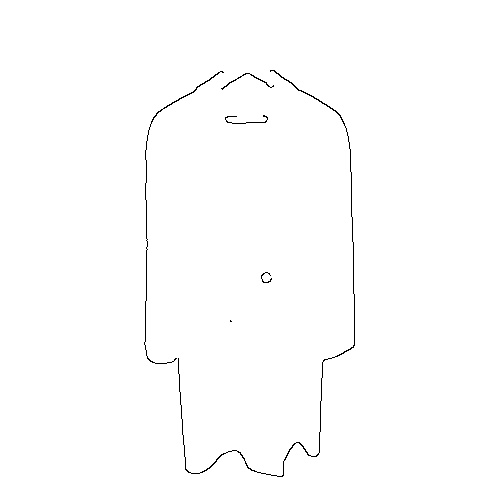

In [54]:
# Example usage
sketch_list = get_image_paths('./dataset/karol-skorulski/karol-skorulski_edge_new', 
                              './dataset/ghoumrassi/ghoumrassi_edge_new')

sketch_path = np.random.choice(sketch_list)
sketch = Image.open(sketch_path).convert('L')
sketch

In [57]:
caption = "a long winter coat"

caption: a long winter coat


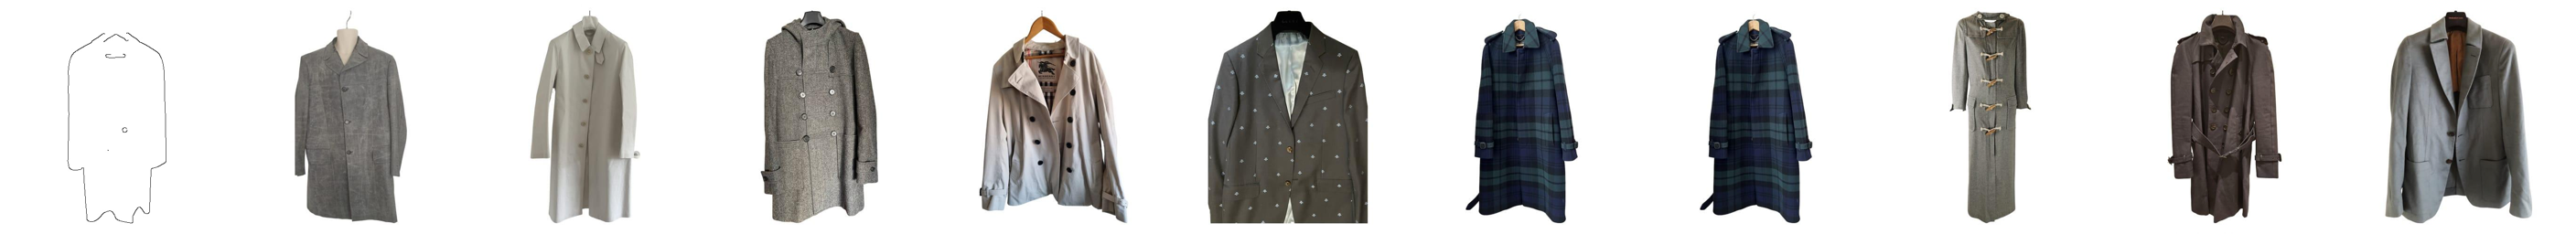

In [58]:
query_feat = get_feature(model, sketch, caption, preprocess_val)
im_list = [sketch] + get_image_list(query_feat, nbrs, all_image_paths)
result_image = get_concat_hn(im_list)

print('caption: '+ caption)
display(result_image) 